In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
 
# Load the dataset
# file_path = 'C:/Users/JayasankariRR/Desktop/DS_mini/merged_data 3 1.csv'
file_path = 'C:/Users/RAAJKOMAHAN/Desktop/DS_mini/data.csv'  # ✅ Works fine


df = pd.read_csv(file_path)
 
# Display the first few rows of the dataset
print("Dataset Preview:")
print(df.head())
 
# Data Cleaning
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())
 
# Fill missing values (example: filling numerical columns with 0 and categorical with mode)
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns
 
df[numerical_columns] = df[numerical_columns].fillna(0)
for col in categorical_columns:
    df[col] = df[col].fillna(df[col].mode()[0])
 
df['churn_utilization'] = (
    (df['seat_utilization'] < 0.2) |
    (df['agent_utilization'] < 0.2)
).astype(int)
 
# Group by 'id' and calculate the average of current_arr and future_arr for each id
grouped_df = df.groupby('id').agg({
    'current_arr': 'mean',
    'future_arr': 'mean',
    'churn_utilization': 'max'  # If any row for the id has churn_utilization = 1, set it to 1
}).reset_index()
 
# Add a churn column based on the condition avg(future_arr) < avg(current_arr)
grouped_df['churn'] = (grouped_df['future_arr'] < grouped_df['current_arr']).astype(int)
 
# Merge the churn column back into the original dataset
df = df.merge(grouped_df[['id', 'churn']], on='id', how='left')
 
# Drop intermediate columns if not needed
df = df.drop(columns=['churn_utilization'])
 
# Display the updated dataset with the churn column
print("\nUpdated Dataset with Churn Column:")
print(df.head())
 
# Save the updated dataset to a new CSV file
# output_file_path = 'C:/Users/JayasankariRR/Desktop/DS_mini/updated_dataset_with_churn.csv'  # Update with your desired file path
output_file_path  = 'C:/Users/RAAJKOMAHAN/Desktop/DS_mini/updated_dataset_with_churn.csv'

df.to_csv(output_file_path, index=False)
 
print(f"\nUpdated dataset with 'churn' column has been saved to: {output_file_path}")

Dataset Preview:
              id  score_date  segment_smb  segment_non_smb  \
0   JMAN_2429072  2023-02-10            1                0   
1   JMAN_9043466  2023-01-13            0                1   
2   JMAN_2452556  2023-02-24            0                1   
3   JMAN_2455113  2023-03-03            0                1   
4  JMAN_18127937  2023-02-10            0                1   

   segment_commercial  segment_enterprise  segment_midmarket  region_emea  \
0                   0                   0                  0            1   
1                   1                   0                  0            1   
2                   0                   0                  0            1   
3                   0                   0                  0            1   
4                   0                   0                  0            1   

   region_apac  region_latam  ...  max_seats  agent_utilization  \
0            0             0  ...        2.0           0.500000   
1            

In [ ]:
pip install scipy
from scipy import stats

Utilization p-value: 0.0000


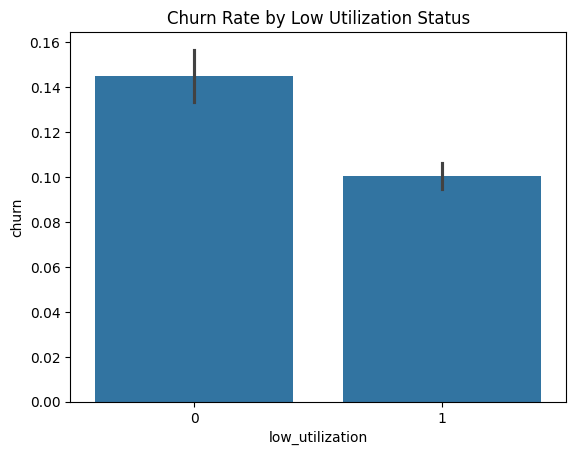

In [10]:
# Create composite utilization flag
df['low_utilization'] = ((df['seat_utilization'] < 0.2) | 
                        (df['agent_utilization'] < 0.2)).astype(int)

# Chi-square test
contingency_table = pd.crosstab(df['low_utilization'], df['churn'])
chi2, pval, _, _ = stats.chi2_contingency(contingency_table)
print(f"Utilization p-value: {pval:.4f}")

# Visualize
sns.barplot(x='low_utilization', y='churn', data=df)
plt.title('Churn Rate by Low Utilization Status')
plt.show()

C:\Users\RAAJKOMAHAN\AppData\Local\Temp\ipykernel_28212\4116974340.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['churn'], y=df['product_counts'], palette="Set2")


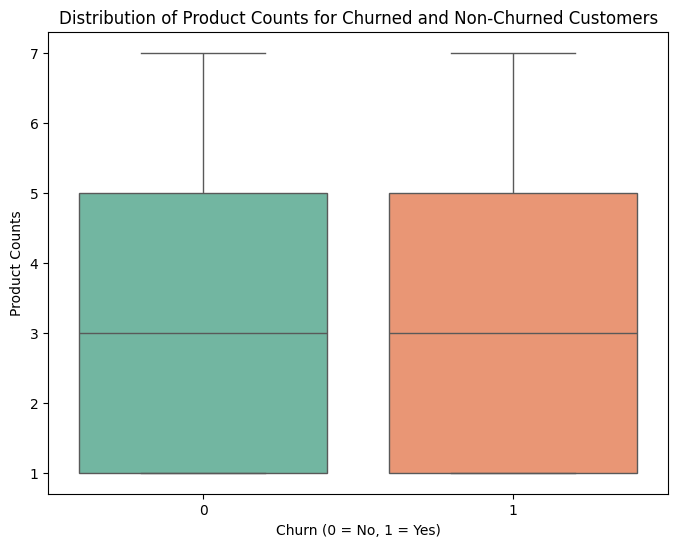

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot size
plt.figure(figsize=(8, 6))

# Create a box plot
sns.boxplot(x=df['churn'], y=df['product_counts'], palette="Set2")

# Set labels and title
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Product Counts")
plt.title("Distribution of Product Counts for Churned and Non-Churned Customers")

# Show the plot
plt.show()


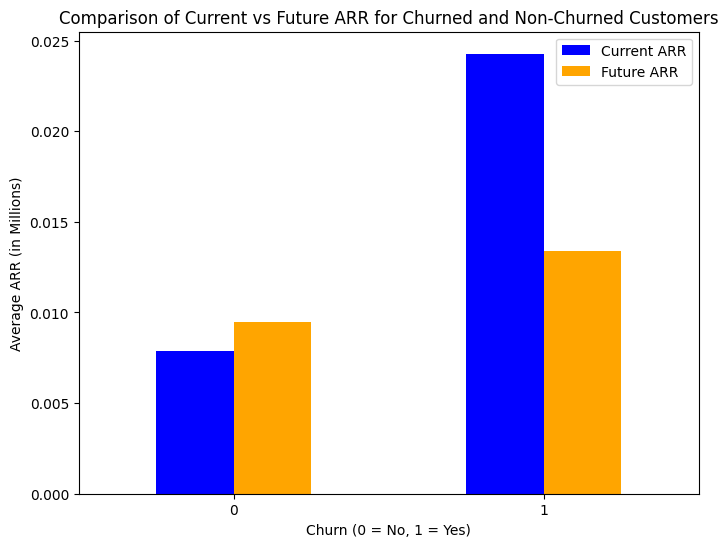

In [14]:
# Convert ARR to millions
df['future_arr_million'] = df['future_arr'] / 1_000_000  
df['current_arr_million'] = df['current_arr'] / 1_000_000  

# Calculate average ARR for churned vs. non-churned customers
arr_summary = df.groupby('churn')[['current_arr_million', 'future_arr_million']].mean()

# Plot bar chart
arr_summary.plot(kind='bar', figsize=(8, 6), color=['blue', 'orange'])

# Labels and title
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Average ARR (in Millions)")
plt.title("Comparison of Current vs Future ARR for Churned and Non-Churned Customers")
plt.xticks(rotation=0)
plt.legend(["Current ARR", "Future ARR"])

# Show plot
plt.show()

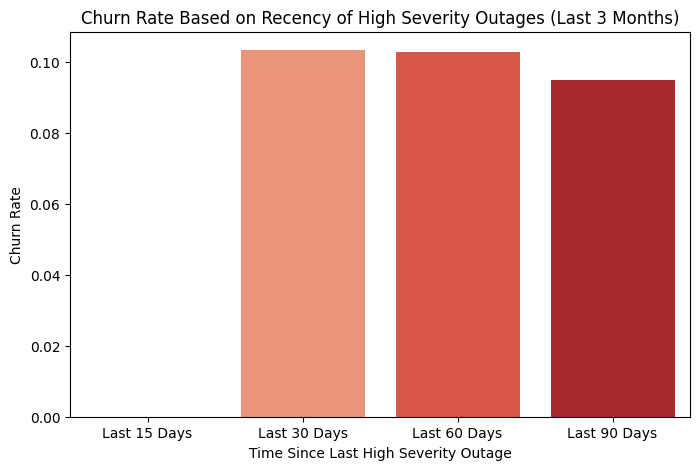

In [21]:
# Define bins for recency of high-severity outages (3-month period)
df['recency_category'] = pd.cut(df['months_since_high_sev_outage'], 
                                bins=[0, 0.5, 1, 2, 3], 
                                labels=['Last 15 Days', 'Last 30 Days', 'Last 60 Days', 'Last 90 Days'],
                                ordered=True)

# Calculate churn rate for each category (set observed=False to remove warning)
churn_by_recency = df.groupby('recency_category', observed=False)['churn'].mean().reset_index()

# Plot bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x='recency_category', y='churn', hue='recency_category', data=churn_by_recency, palette="Reds", legend=False)

# Labels and title
plt.xlabel("Time Since Last High Severity Outage")
plt.ylabel("Churn Rate")
plt.title("Churn Rate Based on Recency of High Severity Outages (Last 3 Months)")
plt.xticks(rotation=0)  # Keep labels horizontal

# Show plot
plt.show()

<Figure size 1200x600 with 0 Axes>

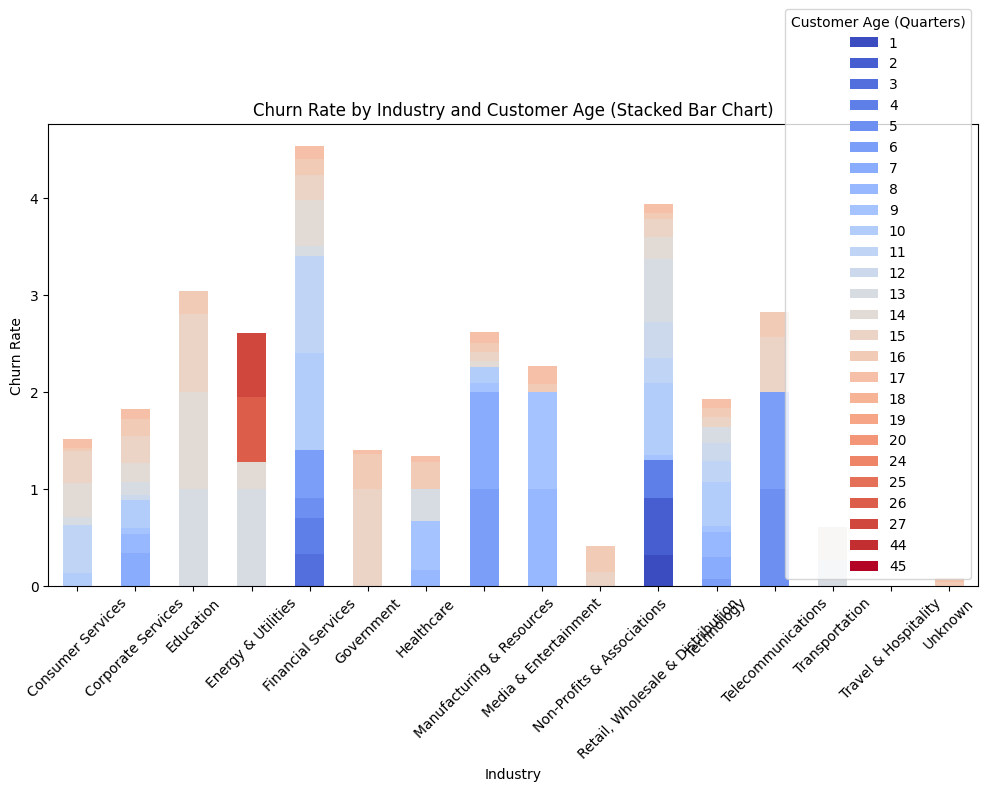

In [30]:
plt.figure(figsize=(12, 6))

# Create a stacked bar chart
df_grouped = df.groupby(["crm_industry_current", "customer_age_quarters"])["churn"].mean().unstack()
df_grouped.plot(kind="bar", stacked=True, colormap="coolwarm", figsize=(12, 6))

# Labels and title
plt.xlabel("Industry")
plt.ylabel("Churn Rate")
plt.title("Churn Rate by Industry and Customer Age (Stacked Bar Chart)")
plt.xticks(rotation=45)
plt.legend(title="Customer Age (Quarters)")

# Show the plot
plt.show()


C:\Users\RAAJKOMAHAN\AppData\Local\Temp\ipykernel_28212\819012175.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  discount_churn = df.groupby(['discount_category', 'churn']).size().unstack()


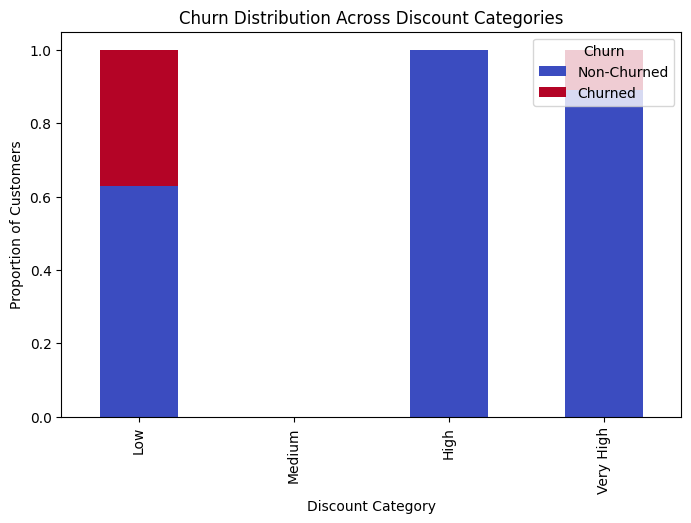

In [35]:
# Define discount categories using fixed thresholds
bins = [0, 10, 20, 50, 100]  # Adjust based on your data range
labels = ['Low', 'Medium', 'High', 'Very High']
df['discount_category'] = pd.cut(df['discount_arr_usd_percentage'], bins=bins, labels=labels, include_lowest=True)

# Count churned and non-churned customers in each discount category
discount_churn = df.groupby(['discount_category', 'churn']).size().unstack()

# Normalize to get proportions
discount_churn = discount_churn.div(discount_churn.sum(axis=1), axis=0)

# Plot stacked bar chart
discount_churn.plot(kind='bar', stacked=True, figsize=(8, 5), colormap="coolwarm")

# Labels and title
plt.xlabel("Discount Category")
plt.ylabel("Proportion of Customers")
plt.title("Churn Distribution Across Discount Categories")
plt.legend(["Non-Churned", "Churned"], title="Churn", loc="upper right")

# Show the plot
plt.show()


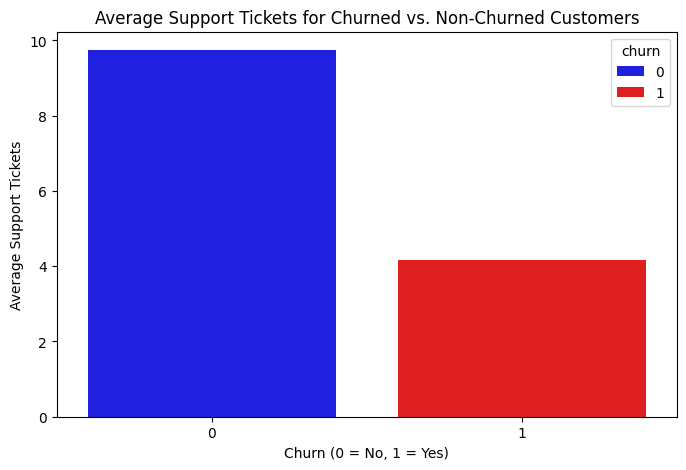

In [40]:

# Fill NaN values correctly
df['num_tickets_deflected'] = df['num_tickets_deflected'].fillna(0)

# Group by churn status and compute average ticket mentions
churn_ticket = df.groupby('churn', observed=True)['num_tickets_deflected'].mean().reset_index()

# Plot bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x="churn", y="num_tickets_deflected", data=churn_ticket, hue="churn", dodge=False, palette=["blue", "red"])

# Labels and title
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Average Support Tickets")
plt.title("Average Support Tickets for Churned vs. Non-Churned Customers")

# Show the plot
plt.show()


C:\Users\RAAJKOMAHAN\AppData\Local\Temp\ipykernel_28212\3045504221.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=billing_churn['billing_dunning_not_ok'], y=billing_churn['churn'], palette=["blue", "red"])


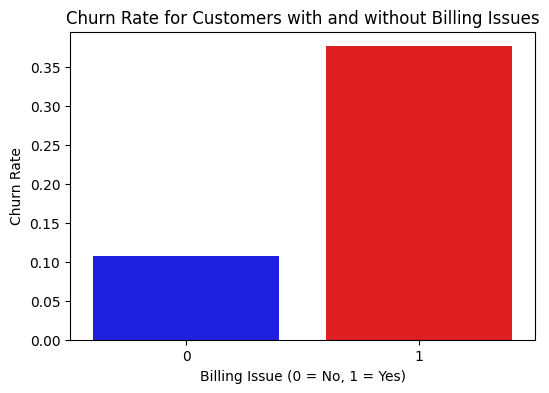

In [42]:
# Convert billing_dunning_not_ok to string type
df['billing_dunning_not_ok'] = df['billing_dunning_not_ok'].astype(str)

# Group by billing issue status and calculate churn rate
billing_churn = df.groupby('billing_dunning_not_ok')['churn'].mean().reset_index()

plt.figure(figsize=(6, 4))

# Use a list-based palette instead of a dictionary
sns.barplot(x=billing_churn['billing_dunning_not_ok'], y=billing_churn['churn'], palette=["blue", "red"])

plt.xlabel("Billing Issue (0 = No, 1 = Yes)")
plt.ylabel("Churn Rate")
plt.title("Churn Rate for Customers with and without Billing Issues")

plt.show()

C:\Users\RAAJKOMAHAN\AppData\Local\Temp\ipykernel_28212\904376602.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Region', y='churn', data=region_churn, palette='coolwarm')


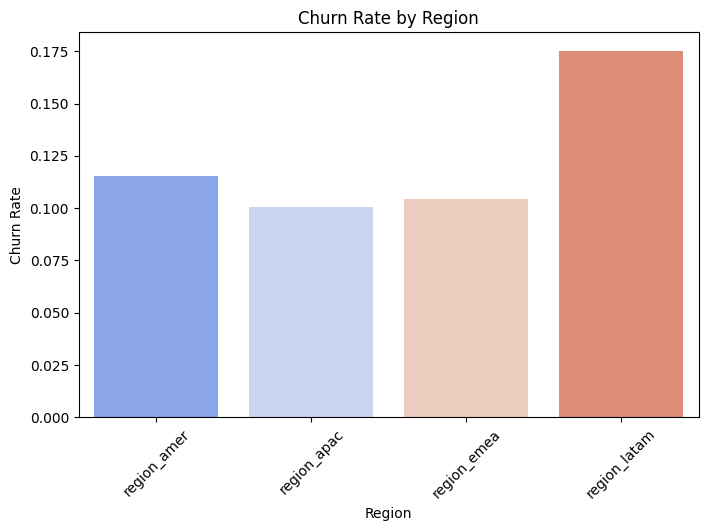

In [43]:
# Melt the region columns into a single column
region_columns = ['region_emea', 'region_apac', 'region_latam', 'region_amer']
df_melted = df.melt(id_vars=['churn'], value_vars=region_columns, var_name='Region', value_name='Presence')

# Filter only rows where the region is 1 (customer belongs to that region)
df_regions = df_melted[df_melted['Presence'] == 1]

# Compute churn rate per region
region_churn = df_regions.groupby('Region')['churn'].mean().reset_index()

# Plot bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x='Region', y='churn', data=region_churn, palette='coolwarm')

plt.xlabel("Region")
plt.ylabel("Churn Rate")
plt.title("Churn Rate by Region")
plt.xticks(rotation=45)
plt.show()